In [1]:
import os
import tempfile

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import torch
import skmisc
import anndata
import numpy as np
scvi.settings.seed = 0
import pandas as pd
import decoupler as dc

import time

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a fu

In [2]:
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats


Load in some scBaseCount datasets. These are not all the datasets available on scBaseCount, nor are they all the datasets for the associated studies, but they are at least a reasonable if narrow cross-section.

In [3]:
accessions = ['SRX21302118','SRX21302117','SRX20906789','SRX20906790',
              'SRX20906791','SRX20906787','SRX20906788','ERX11456530','ERX11456531',\
                'ERX11456526','ERX11456524','ERX11456525','ERX11456527','SRX22782387',\
              'SRX22782386','SRX22782388','SRX22782389']


In [4]:
ads=[sc.read_h5ad('/home/gennady/curation-results/scBaseCamp/heart/{}.h5ad'.format(x)) for x in accessions]

In [5]:
knees = []
for ad in ads:
    knee = np.sort((np.array(ad.X.sum(axis=1))).flatten())[::-1]
    knees.append(knee)


Text(0, 0.5, 'UMI counts')

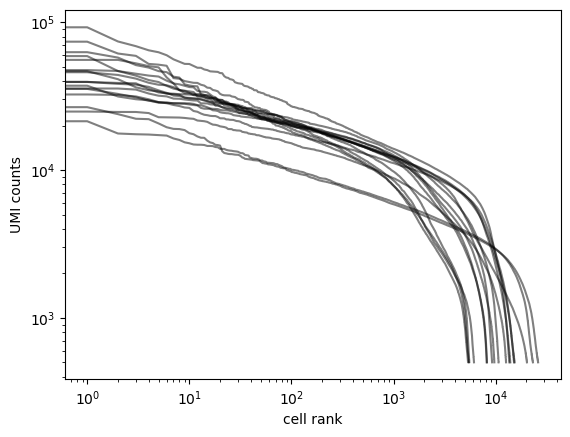

In [6]:
for i in range(len(ads)):
    plt.plot(range(len(knees[i])),knees[i],color='k',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('cell rank')
plt.ylabel('UMI counts')


In [7]:
# ads

In [8]:
ad = anndata.concat(ads,keys=accessions,label='SampleID',axis=0)

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
def scVI_workflow(ad,samplename,sampledir,batch_key='SampleID',n_top_genes=2000,max_epochs=300):
    
    ad.write(f'{sampledir}/{samplename}.h5ad.gz',compression='gzip')
    print(ad.shape)
    try:
        sc.pp.highly_variable_genes(
            ad, flavor="seurat_v3", n_top_genes=n_top_genes, subset=True,batch_key=batch_key)
    except:
        sc.pp.highly_variable_genes(
            ad, flavor="seurat_v3", n_top_genes=n_top_genes, subset=True)
    print(ad.shape)
    scvi.model.SCVI.setup_anndata(ad, layer=None, batch_key=batch_key)
    model = scvi.model.SCVI(ad, n_latent=10, dispersion='gene', gene_likelihood='nb')
    model.train(max_epochs=max_epochs, accelerator='gpu', plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)
    train_elbo = model.history["elbo_train"][1:]
    test_elbo = model.history["elbo_validation"]
    print(ad.shape)
    ax = train_elbo.plot()
    test_elbo.plot(ax=ax)
    Z_hat = model.get_latent_representation()
    model_dir=f'/home/gennady/notebooks/gg2401_sn_13lgs/scvi/{samplename}'
    model.save(model_dir, save_anndata=False)

    SCVI_LATENT_KEY = "X_scVI"
    
    ad.obsm[SCVI_LATENT_KEY] = Z_hat
    sc.pp.neighbors(ad, use_rep=SCVI_LATENT_KEY, n_neighbors=25)
    t1=time.time()
    sc.tl.leiden(ad, key_added="leiden_scVI_02", resolution=0.2)
    sc.tl.leiden(ad, key_added="leiden_scVI_04", resolution=0.4)
    sc.tl.leiden(ad, key_added="leiden_scVI_06", resolution=0.6)
    sc.tl.leiden(ad, key_added="leiden_scVI_08", resolution=0.8)
    sc.tl.leiden(ad, key_added="leiden_scVI_10", resolution=1.0)
    sc.tl.leiden(ad, key_added="leiden_scVI_12", resolution=1.2)
    sc.tl.leiden(ad, key_added="leiden_scVI_14", resolution=1.4)
    t2=time.time()
    print('clustering time: '+str(t2-t1))

    sc.tl.umap(ad, min_dist=0.3)

    ad_allgenes=sc.read_h5ad(f'{sampledir}/{samplename}.h5ad.gz')
    print(ad.shape)
    for key in ad.obs.keys():
        ad_allgenes.obs[key]=ad.obs[key]
    for key in ad.uns.keys():
        ad_allgenes.uns[key]=ad.uns[key]
    for key in ad.obsm.keys():
        ad_allgenes.obsm[key]=ad.obsm[key]
    for key in ad.obsp.keys():
        ad_allgenes.obsp[key]=ad.obsp[key]
    ad=ad_allgenes.copy()
    print(ad.shape)
    ad.write(f'{sampledir}/{samplename}.h5ad.gz',compression='gzip')
    return ad

In [10]:
ad

AnnData object with n_obs × n_vars = 208583 × 32285
    obs: 'gene_count', 'umi_count', 'SRX_accession', 'SampleID'

In [11]:
assert all([(ad.var.index==ad_.var.index).all() for ad_ in ads])
ad.var=ads[0].var.copy()
ad.obs_names_make_unique()
ad.var.set_index('gene_symbols',inplace=True,drop=True)
ad.var.drop(columns='feature_types',inplace=True)
ad.obs.drop(columns='SRX_accession',inplace=True)
ad.var.index=ad.var.index.astype(str)
ad.var_names_make_unique()
ad.write('/home/gennady/curation-results/scBaseCamp/heart/gg_250912_mouse_heart.h5ad.gz',compression='gzip')


In [13]:
ad

AnnData object with n_obs × n_vars = 208583 × 32285
    obs: 'gene_count', 'umi_count', 'SampleID'

(208583, 32285)
(208583, 1000)


/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scvi/model/_scvi.py:127: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/lightning/fabric/accelerators/cuda.py:239: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 150/150: 100%|███████████████████████████████████████████████████████████| 150/150 [33:05<00:00, 13.07s/it, v_num=1, train_loss_step=161, train_loss_epoch=183]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|███████████████████████████████████████████████████████████| 150/150 [33:05<00:00, 13.24s/it, v_num=1, train_loss_step=161, train_loss_epoch=183]
(208583, 1000)
clustering time: 1177.926911830902
(208583, 1000)
(208583, 32285)


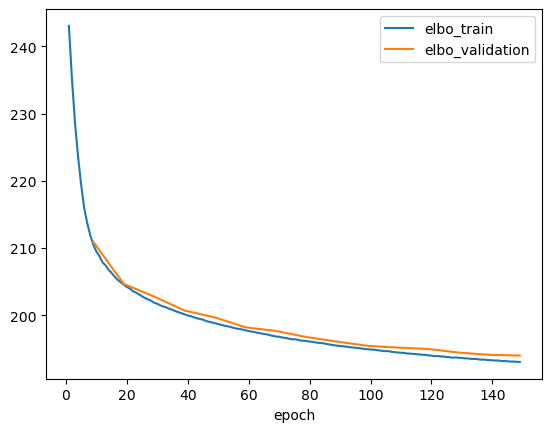

In [14]:
ad_scVI=scVI_workflow(ad.copy(),'gg_250912_mouse_heart','/home/gennady/curation-results/scBaseCamp/heart/scVI/',batch_key=None,
                     n_top_genes=1000,max_epochs=150)

In [15]:
ad_scVI

AnnData object with n_obs × n_vars = 208583 × 32285
    obs: 'gene_count', 'umi_count', 'SampleID', '_scvi_batch', '_scvi_labels', 'leiden_scVI_02', 'leiden_scVI_04', 'leiden_scVI_06', 'leiden_scVI_08', 'leiden_scVI_10', 'leiden_scVI_12', 'leiden_scVI_14'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'leiden', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'distances', 'connectivities'

In [17]:
ad=sc.read_h5ad('/home/gennady/curation-results/scBaseCamp/heart/scVI/gg_250912_mouse_heart.h5ad.gz')

In [18]:
ad

AnnData object with n_obs × n_vars = 208583 × 32285
    obs: 'gene_count', 'umi_count', 'SampleID', '_scvi_batch', '_scvi_labels', 'leiden_scVI_02', 'leiden_scVI_04', 'leiden_scVI_06', 'leiden_scVI_08', 'leiden_scVI_10', 'leiden_scVI_12', 'leiden_scVI_14'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [19]:

ad.raw=ad.copy()
sc.pp.log1p(ad)

In [22]:
sc.tl.rank_genes_groups(ad, groupby='leiden_scVI_02', groups='all',reference='rest',use_raw=False,method='t-test')

In [25]:
ad

AnnData object with n_obs × n_vars = 208583 × 32285
    obs: 'gene_count', 'umi_count', 'SampleID', '_scvi_batch', '_scvi_labels', 'leiden_scVI_02', 'leiden_scVI_04', 'leiden_scVI_06', 'leiden_scVI_08', 'leiden_scVI_10', 'leiden_scVI_12', 'leiden_scVI_14'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'neighbors', 'umap', 'log1p', 'leiden_scVI_02_colors', 'rank_genes_groups'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [27]:
sc.tl.dendrogram(ad,groupby='leiden_scVI_02',use_rep='X_scVI')

/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


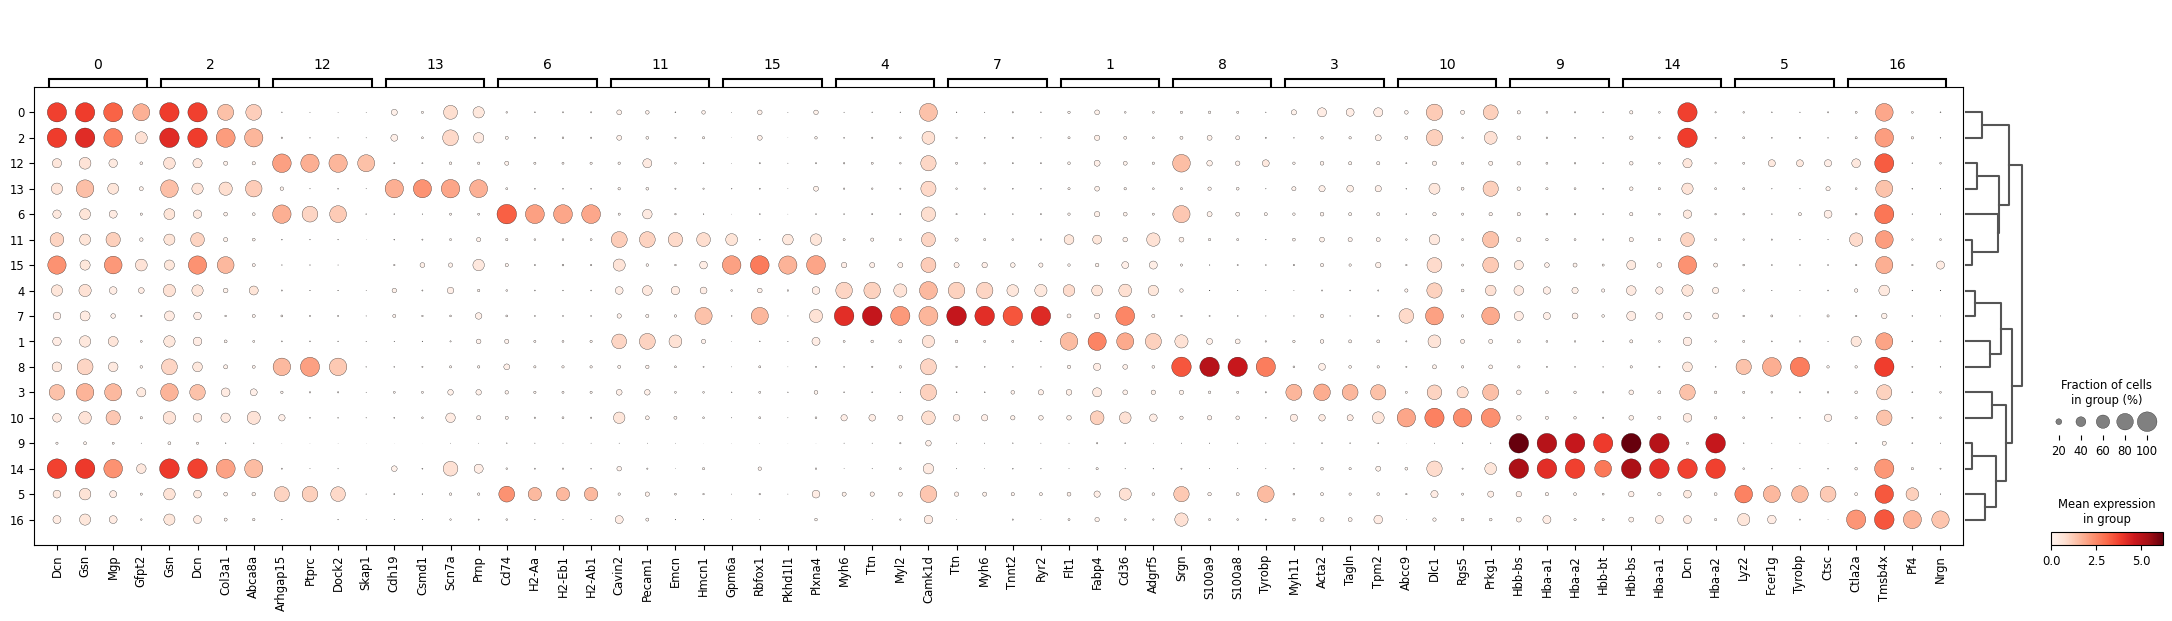

In [28]:
sc.pl.rank_genes_groups_dotplot(ad, n_genes=4,use_raw=False)


In [29]:
de=sc.get.rank_genes_groups_df(ad,group='13')
de.set_index('names',inplace=True)

In [30]:
de.loc[['Plp1','Mpz','Scn7a']]

,scores,logfoldchanges,pvals,pvals_adj
names,,,,
Plp1,63.931824,7.940760,0.000000e+00,0.000000e+00
Mpz,10.662592,6.002561,7.397025e-26,4.331029e-25
Scn7a,75.852119,3.712512,0.000000e+00,0.000000e+00


In [31]:
de.loc[['Xist']]

,scores,logfoldchanges,pvals,pvals_adj
names,,,,
Xist,-0.358687,-0.327988,0.719866,0.857819


/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/gennady/miniconda3/envs/scVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


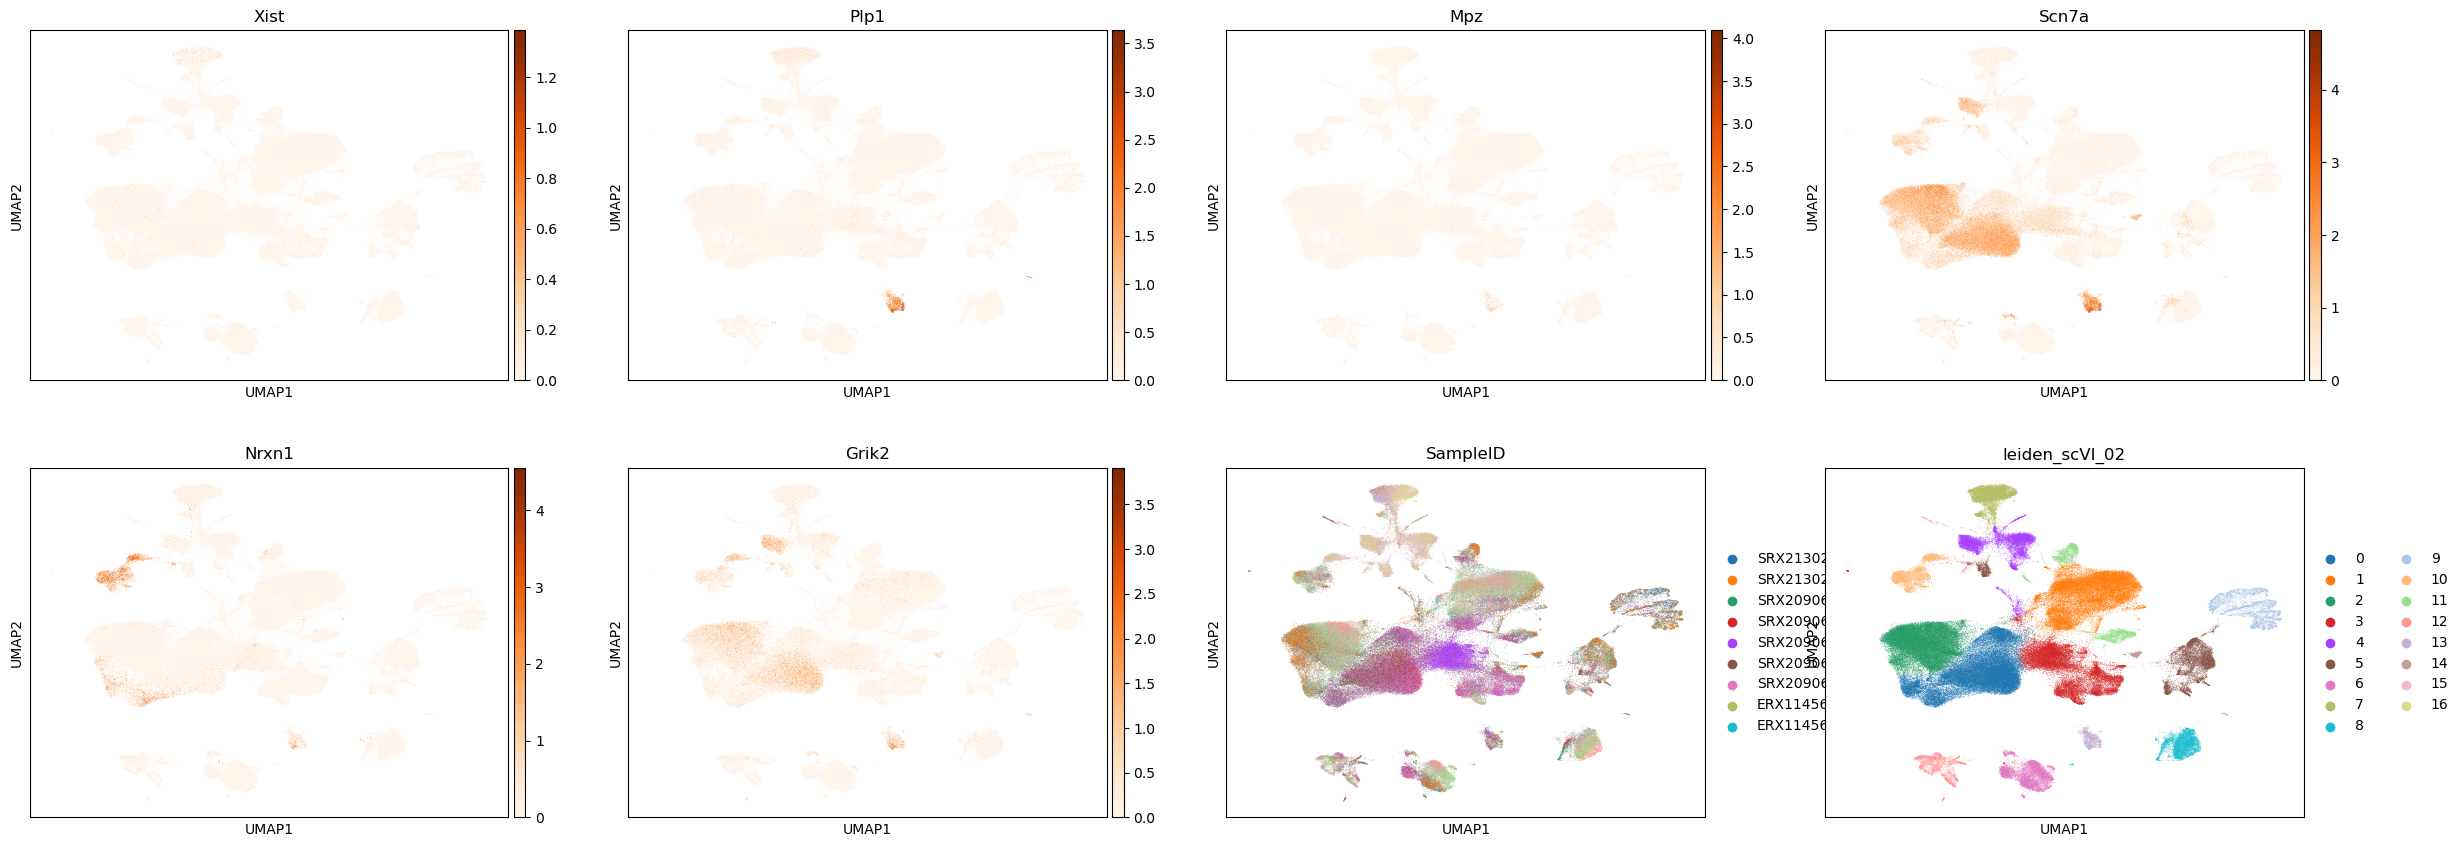

In [49]:
sc.pl.umap(ad,color=['Xist','Plp1','Mpz','Scn7a','Nrxn1','Grik2','SampleID','leiden_scVI_02'],use_raw=False, cmap='Oranges')

In [48]:
(ad.obs['leiden_scVI_02']=='13').sum()

2006

In [42]:
psbulk = dc.get_pseudobulk(ad,sample_col='SampleID',groups_col='leiden_scVI_02',use_raw=True,mode="sum",min_cells=0,min_counts=0)

In [46]:
psbulk[psbulk.obs['leiden_scVI_02']=='13','Xist'].X.toarray().squeeze().astype(int)

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [50]:
psbulk_glob = dc.get_pseudobulk(ad,sample_col='SampleID',groups_col=None,use_raw=True,mode="sum",min_cells=0,min_counts=0)

In [55]:
psbulk_glob[:,['Ddx3y','Kdm5d','Uty','Xist']].X.toarray().squeeze().astype(int)

array([[ 5230,  1012,  3383,    13],
       [ 6255,  1089,  4108,     6],
       [ 5364,   926,  3216,    12],
       [ 8405,  1669,  6583,    13],
       [ 7208,  1186,  3972,    10],
       [ 6806,  1526,  5014,    16],
       [14182,  1065,  5576,     8],
       [16476,   910,  5456,    13],
       [13759,   953,  6499,    22],
       [16738,  1086,  6327,    13],
       [13682,   940,  5362,    16],
       [ 5865,  1203,  3482,    13],
       [ 6677,  1159,  3775,    13],
       [ 3618,  1562,  8092,    33],
       [ 3090,  1206,  6517,    30],
       [ 2941,  1166,  6229,    14],
       [ 2706,   894,  5526,    19]])

In [59]:
print(psbulk_glob[:,['Ddx3y','Kdm5d','Uty','Xist']].X.toarray().squeeze().astype(int).min(0))
print(psbulk_glob[:,['Ddx3y','Kdm5d','Uty','Xist']].X.toarray().squeeze().astype(int).max(0))

[2706  894 3216    6]
[16738  1669  8092    33]


In [ ]:
del psbulk.uns['_scvi_manager_uuid'] 
del psbulk.uns['_scvi_uuid']
del psbulk_glob.uns['_scvi_manager_uuid']
del psbulk_glob.uns['_scvi_uuid']


In [72]:
psbulk.obs.drop(columns='_scvi_batch',inplace=True)
psbulk_glob.obs.drop(columns='_scvi_batch',inplace=True)
psbulk.obs.drop(columns='_scvi_labels',inplace=True)
psbulk_glob.obs.drop(columns='_scvi_labels',inplace=True)

In [75]:
psbulk.write_h5ad('/home/gennady/curation-results/scBaseCamp/heart/scVI/gg_250912_mouse_heart_l02_psbulk.h5ad.gz',compression='gzip')
psbulk_glob.write_h5ad('/home/gennady/curation-results/scBaseCamp/heart/scVI/gg_250912_mouse_heart_l02_globpsbulk.h5ad.gz',compression='gzip')
